<a href="https://colab.research.google.com/github/sayanbanerjee32/keyword_search/blob/main/Smart_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a super smart search engine over any free text data source

This code acompanies the following blog posts by https://medium.com/@thejoshtaylor


In [40]:
%%capture
import os
import pandas as pd
import numpy as np
import pickle
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText
!pip install rank_bm25 --quiet #install BM25
!pip install --no-binary :all: nmslib #install nmslib
from rank_bm25 import BM25Okapi
import nmslib
import time
from google.colab import drive
!pip install clean-text[gpl]
from cleantext import clean

# drive.mount('/content/drive') # if you want to use G Drive
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')


In [2]:
!gdown --id 13LLeNj9Fajk0PBd7U5kXEhsEpSRMWwbJ

Downloading...
From: https://drive.google.com/uc?id=13LLeNj9Fajk0PBd7U5kXEhsEpSRMWwbJ
To: /content/export.csv
145MB [00:01, 139MB/s]


### Load data and create DF

In [3]:
#LINK TO DATASET USED:
# https://drive.google.com/file/d/13LLeNj9Fajk0PBd7U5kXEhsEpSRMWwbJ/view?usp=sharing

import pandas as pd
df = pd.read_csv('export.csv')
df['text'] = df['tendertitle'] + ' ' + df['tenderdescription']+ ' ' + df['locality']+ ' ' + df['postalCode']
df.shape


(212447, 6)

In [4]:
df.head(1)

,externalid,tendertitle,tenderdescription,locality,postalCode,text
0,00227ecd-50ac-4f92-9e7f-d2675663efa2,TELEPHONY SERVICES,TELEPHONY SERVICES,Exeter,EX1 3PB,TELEPHONY SERVICES TELEPHONY SERVICES Exeter EX1 3PB


### Preprocess and tokenise

In [37]:
def fix_text(txt):
    return clean(txt,
                fix_unicode=True,               # fix various unicode errors
                to_ascii=True,                  # transliterate to closest ASCII representation
                lower=True,                     # lowercase text
                no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
                no_urls=True,                  # replace all URLs with a special token
                no_emails=True,                # replace all email addresses with a special token
                no_phone_numbers=True,         # replace all phone numbers with a special token
                no_numbers=True,               # replace all numbers with a special token
                no_digits=True,                # replace all digits with a special token
                no_currency_symbols=True,      # replace all currency symbols with a special token
                no_punct=True,                 # remove punctuations
                replace_with_punct="<PUNCT>",          # instead of removing punctuations you may replace them
                replace_with_url="<URL>",
                replace_with_email="<EMAIL>",
                replace_with_phone_number="<PHONE>",
                replace_with_number="<NUMBER>",
                replace_with_digit="0",
                replace_with_currency_symbol="<CUR>",
                lang="en"                       # set to 'de' for German special handling
            )

In [ ]:
nlp = spacy.load("en_core_web_sm")
tok_text=[] # for our tokenised corpus
text = df.text.str.lower().values
text = [fix_text(str(i)) for i in text]
# text = [str(i) for i in text]
#Tokenising using SpaCy:
for doc in tqdm(nlp.pipe(text, n_threads=2, disable=["tagger", "parser","ner"])):
    tok = [t.text for t in doc if (t.is_ascii and not t.is_punct and not t.is_space)]
    tok_text.append(tok)


### Fast text

In [6]:
ft_model = FastText(
    sg=1, # use skip-gram: usually gives better results
    size=100, # embedding dimension (default)
    window=10, # window size: 10 tokens before and 10 tokens after to get wider context
    min_count=5, # only consider tokens with at least n occurrences in the corpus
    negative=15, # negative subsampling: bigger than default to sample negative examples more
    min_n=2, # min character n-gram
    max_n=5 # max character n-gram
)

ft_model.build_vocab(tok_text)

ft_model.train(
    tok_text,
    epochs=6,
    total_examples=ft_model.corpus_count, 
    total_words=ft_model.corpus_total_words)

ft_model.save('_fasttext.model')

### Load fasttext and query

In [7]:
ft_model = FastText.load('_fasttext.model')

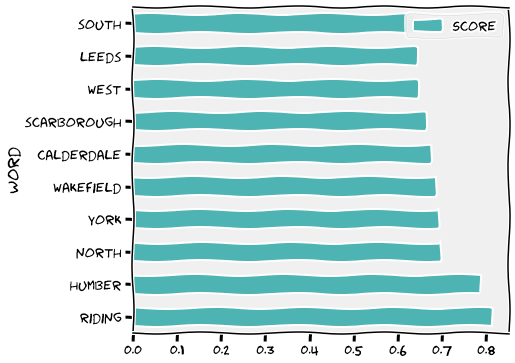

In [8]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("yorkshire", topn=10, restrict_vocab=5000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

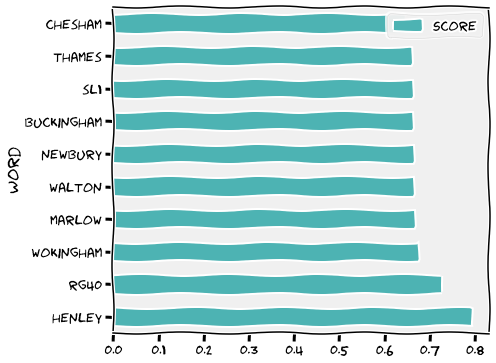

In [9]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("rg9", topn=10, restrict_vocab=10000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

### Creating BM25 document vectors:

In [31]:
bm25 = BM25Okapi(tok_text)
weighted_doc_vects = []
unknown_words = []
embed_vocab = list(ft_model.wv.vocab.keys())
for i,doc in tqdm(enumerate(tok_text)):
  doc_vector = []
  for word in doc:
    if word in embed_vocab:
        vector = ft_model[word]
        weight = (bm25.idf[word] * ((bm25.k1 + 1.0)*bm25.doc_freqs[i][word])) 
        / 
        (bm25.k1 * (1.0 - bm25.b + bm25.b *(bm25.doc_len[i]/bm25.avgdl))+bm25.doc_freqs[i][word])
        weighted_vector = vector * weight
        doc_vector.append(weighted_vector)
    else: unknown_words.append(word)
  doc_vector_mean = np.mean(doc_vector,axis=0)
  weighted_doc_vects.append(doc_vector_mean)
  len(unknown_words)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
212447it [19:14, 184.10it/s]


In [33]:
pickle.dump( weighted_doc_vects, open( "weighted_doc_vects.p", "wb" ) )

### Load document vectors, build index and search:

In [34]:
with open( "weighted_doc_vects.p", "rb" ) as f:
    weighted_doc_vects = pickle.load(f)
# create a random matrix to index
data = np.vstack(weighted_doc_vects)

# initialize a new index, using a HNSW index on Cosine Similarity - can take a couple of mins
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

In [36]:
# querying the index:
input = 'audit services Norwic'


input = fix_text(input).lower().split()

query = [ft_model[vec] for vec in input]
query = np.mean(query,axis=0)

t0 = time.time()
ids, distances = index.knnQuery(query, k=10)
t1 = time.time()
print(f'Searched {df.shape[0]} records in {round(t1-t0,4) } seconds \n')
for i,j in zip(ids,distances):
  print(round(j,2))
  print(df.text.values[i])

Searched 212447 records in 0.0008 seconds 

0.1
PROVISION OF EXTERNAL AUDIT SERVICES THE CONTRACT IS A SINGLE LOT FOR THE PROVISION OF EXTERNAL AUDIT SERVICES. Norwich NR4 6TJ
0.1
PROVISION OF EXTERNAL AUDIT SERVICES THE CONTRACT IS A SINGLE LOT FOR THE PROVISION OF EXTERNAL AUDIT SERVICES. Norwich NR4 6TJ
0.1
PROVISION OF EXTERNAL AUDIT SERVICES THE CONTRACT IS A SINGLE LOT FOR THE PROVISION OF EXTERNAL AUDIT SERVICES. Norwich NR4 6TJ
0.11
GB-NORWICH: EXTERNAL AUDIT ANNUAL AUDIT OF TRUST FINANCIAL & QUALITY ACCOUNTS AND ANNUAL REPORT. Norwich NR6 5BE
0.13
GB-NORWICH: 18-022 - INTERNAL AUDIT SERVICES BROADLAND HOUSING GROUP WISHES TO ENTER INTO A CONTRACT FOR INTERNAL AUDITING. Norwich NR1 1HU
0.13
PURCON637 INTERNAL AUDIT 2015 THE UNIVERSITY OF EAST ANGLIA (UEA) REQUIRES A SERVICE PROVIDER TO SUPPLY AN INTERNAL AUDIT SERVICE IN COMPLIANCE WITH THE HIGHER EDUCATION FUNDING COUNCIL FOR ENGLAND’S (HEFCE) AUDIT CODE OF PRACTICE (CIRCULAR 2004/27) AND TO CONDUCT AN INDEPENDENT APPRAISAL OF

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
